Step 1: Setting Up the Databricks Environment


In [4]:
!pip install pyspark

Step 2: Importing Libraries

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [9]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("WinePCAAnalysis") \
    .getOrCreate()


23/11/29 20:01:37 WARN Utils: Your hostname, MacBook-Air-17.local resolves to a loopback address: 127.0.0.1; using 10.0.0.35 instead (on interface en0)
23/11/29 20:01:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 20:01:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Step 3: Loading the Data

In [10]:
# Reading the data into a DataFrame
wine_data = spark.read.csv("/Users/aviajmera/DimenRed_aviajmera/wine_pca.csv", header=True, inferSchema=True)


Step 4: Data Preprocessing

In [11]:
# Assembling the features into a vector
assembler = VectorAssembler(inputCols=wine_data.columns[1:], outputCol="features")
assembled_data = assembler.transform(wine_data)

# Standardizing the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)


23/11/29 20:01:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Step 5: Applying PCA

In [12]:
# Applying PCA
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_data)
pca_result = pca_model.transform(scaled_data)


23/11/29 20:02:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 20:02:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/11/29 20:02:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Step 6: Clustering Analysis

In [13]:
kmeans = KMeans(featuresCol="pcaFeatures", k=3)
model = kmeans.fit(pca_result)
predictions = model.transform(pca_result)


Step 7: Classification Analysis

In [14]:
# Split the data into training and test sets
train_data, test_data = pca_result.randomSplit([0.7, 0.3])

# Prepare the data for classification
classifier = RandomForestClassifier(labelCol="Type", featuresCol="pcaFeatures")
model = classifier.fit(train_data)
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Type", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)


Step 8: Visualization and Analysis

In [16]:
# Assuming pca_result is the output of the PCA transformation
# Convert the PCA features to a Pandas DataFrame
pca_features_df = pca_result.select("pcaFeatures").toPandas()

# Assuming the PCA model has 6 components, create column names
column_names = [f'PC{i+1}' for i in range(6)]
pca_features_df = pd.DataFrame(pca_features_df['pcaFeatures'].tolist(), columns=column_names)

# Merging with your original predictions DataFrame if needed
pandas_df = predictions.toPandas()
pandas_df = pandas_df.join(pca_features_df)


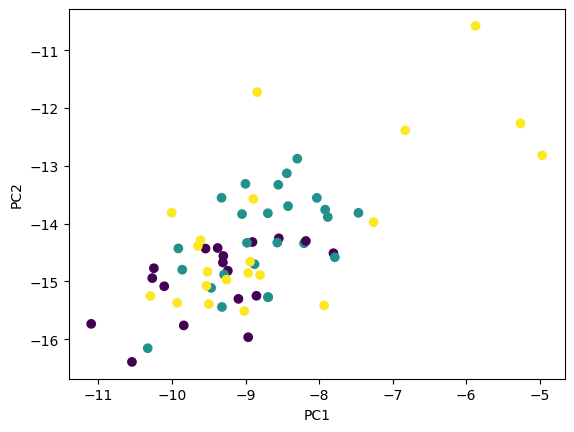

In [17]:
plt.scatter(pandas_df['PC1'], pandas_df['PC2'], c=pandas_df['prediction'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Step 9: Display Results

In [19]:
# Displaying results
display(predictions)




DataFrame[Type: int, Alcohol: double, Malic: double, Ash: double, Alcalinity: double, Magnesium: int, Phenols: double, Flavanoids: double, Nonflavanoids: double, Proanthocyanins: double, Color: double, Hue: double, Dilution: double, Proline: int, features: vector, scaledFeatures: vector, pcaFeatures: vector, rawPrediction: vector, probability: vector, prediction: double]